# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder_debug import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.cv import cross_validate
from base.engine.train import train_midgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 0
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

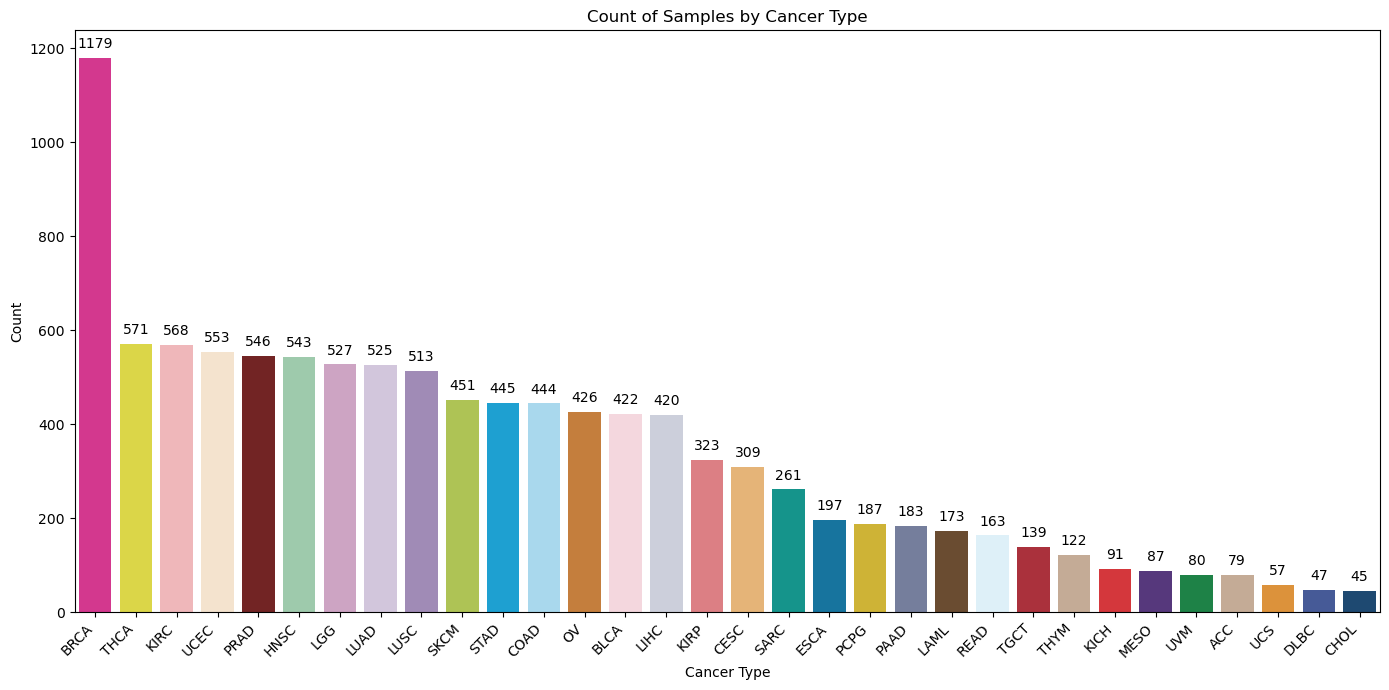

In [6]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

In [7]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio, val_ratio, test_ratio = 0.8, 0.2, 0.

# Calculate split indices
total_samples = len(tcga_mrna)
train_end = int(train_ratio * total_samples)

# Split the data
train_mrna = tcga_mrna.iloc[:train_end]
val_mrna = tcga_mrna.iloc[train_end:]

train_mirna = tcga_mirna.iloc[:train_end]
val_mirna = tcga_mirna.iloc[train_end:]

In [9]:
is_subset = False
n = 5000

if is_subset:
    # Extract the expression data (excluding the last four columns)
    expression_data = train_mrna.iloc[:, :-4]
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(n).index
    selected_columns = expression_data[top_gene].columns

    annot = train_mrna.iloc[:,-4:].columns
    train_mrna = train_mrna[selected_columns.append(annot)]
    val_mrna = val_mrna[selected_columns.append(annot)]

In [10]:
# Train, val, and test data loaders
batch_size = 256

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna)
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers,
                                           pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True,
                                                num_workers=num_workers,
                                                pin_memory=True)

In [11]:
# make data split for train and validation sets
mrna_out_dim = train_mrna.shape[1]-4
mirna_out_dim = train_mirna.shape[1]-4

In [12]:
print(train_dataset.mrna_data.shape)
print(validation_dataset.mrna_data.shape)

print(train_dataset.mirna_data.shape)
print(validation_dataset.mirna_data.shape)
print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([8540, 5000])
torch.Size([2136, 5000])
torch.Size([8540, 2450])
torch.Size([2136, 2450])
5000
2450


In [13]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues

32

# Model Setup

In [14]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 128, 128]
reduction_type = "sum" # output loss reduction

activation = "relu"

In [15]:
# decoder setup

# set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_mirna_layer, output_mrna_layer], activation=activation).to(device)

# setup gmm init
gmm_mean_scale = 10.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20
gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}

In [16]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec=gmm_spec
)

In [17]:
# train for n epochs and plot learning curves
learning_rates = {'dec':0.001,'rep':0.01,'gmm':0.01}
weight_decay = 0.
betas = (0.9, 0.999)

nepochs = 101
pr = 5 # how often to print epoch
plot = 50 # how often to print plot

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
subset = sample_index[0]
sample_index = [0, 10, 20, 300, 1382, 1310, 34, 360, 765, 999, 2000, 93]

In [18]:
print("Hyperparameters:")
print(f"Latent dimension: {latent_dim}")
print(f"Learning rates: {learning_rates}")
print(f"Weight decay: {weight_decay}")
print(f"betas: {betas}")
print(f"Number of epochs: {nepochs}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Batch size: {batch_size}")
print(f"Reduction type: {reduction_type}")

Hyperparameters:
Latent dimension: 20
Learning rates: {'dec': 0.001, 'rep': 0.01, 'gmm': 0.01}
Weight decay: 0.0
betas: (0.9, 0.999)
Number of epochs: 101
Hidden dimensions: [128, 128, 128]
Batch size: 128
Reduction type: sum


# Training

  0%|                                                                                                                                                                                         | 0/101 [00:00<?, ?it/s]

0 train_recon_mirna: 8.907912865028916 train_recon_mrna: 10.642465304449649 train_gmm: 10.432339015844555 train_mse: 80055167.75 train_mae: 14114.169036865234 train_r2: 0.8388769626617432 train_spearman: 18.450203448534012 train_pearson: 8.72234271466732 train_expl_var: 0.8388769626617432 train_msle: 1175.1741828918457
0 test_recon: 20.580797791026523 test_gmm: 7.050180088000351 test_mse: 16180283.0 test_mae: 849.6683349609375 test_r2: 0.01033163070678711 test_spearman: 0.2527790367603302 test_pearson: 0.10706586390733719 test_expl_var: 0.010331690311431885 test_msle: 28.49525260925293


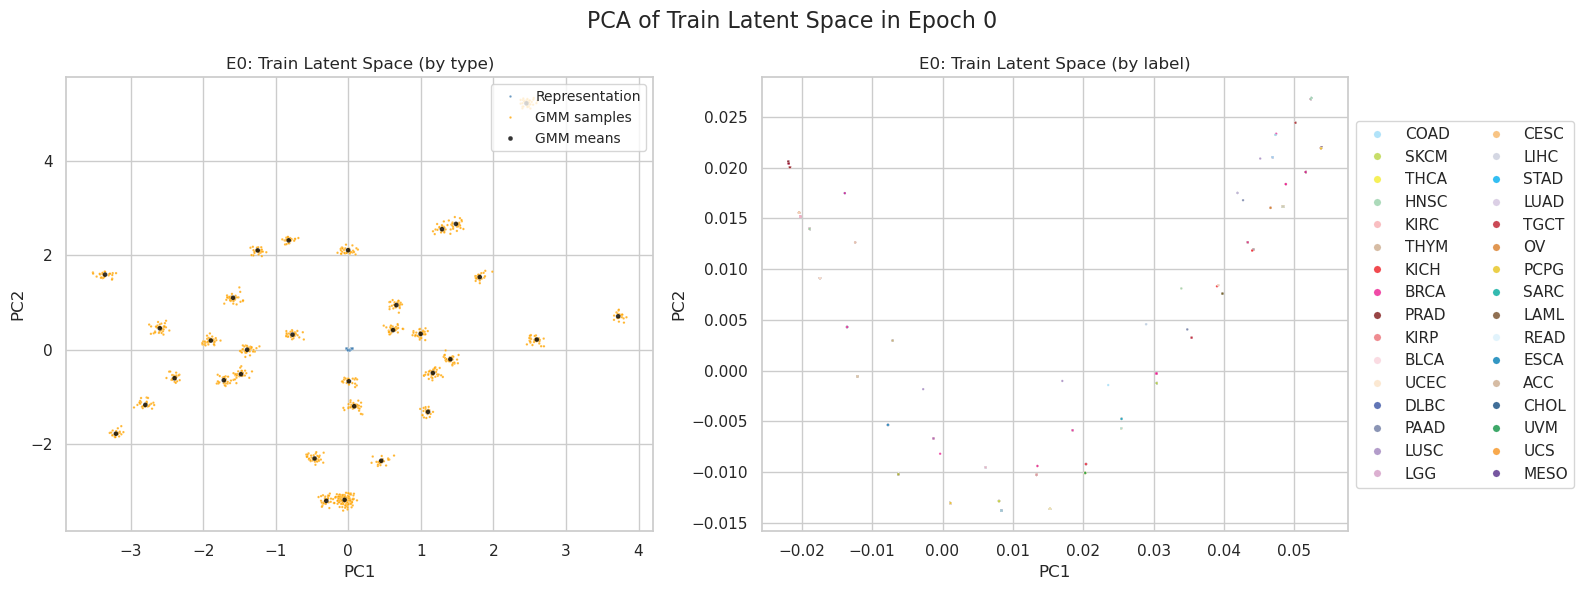

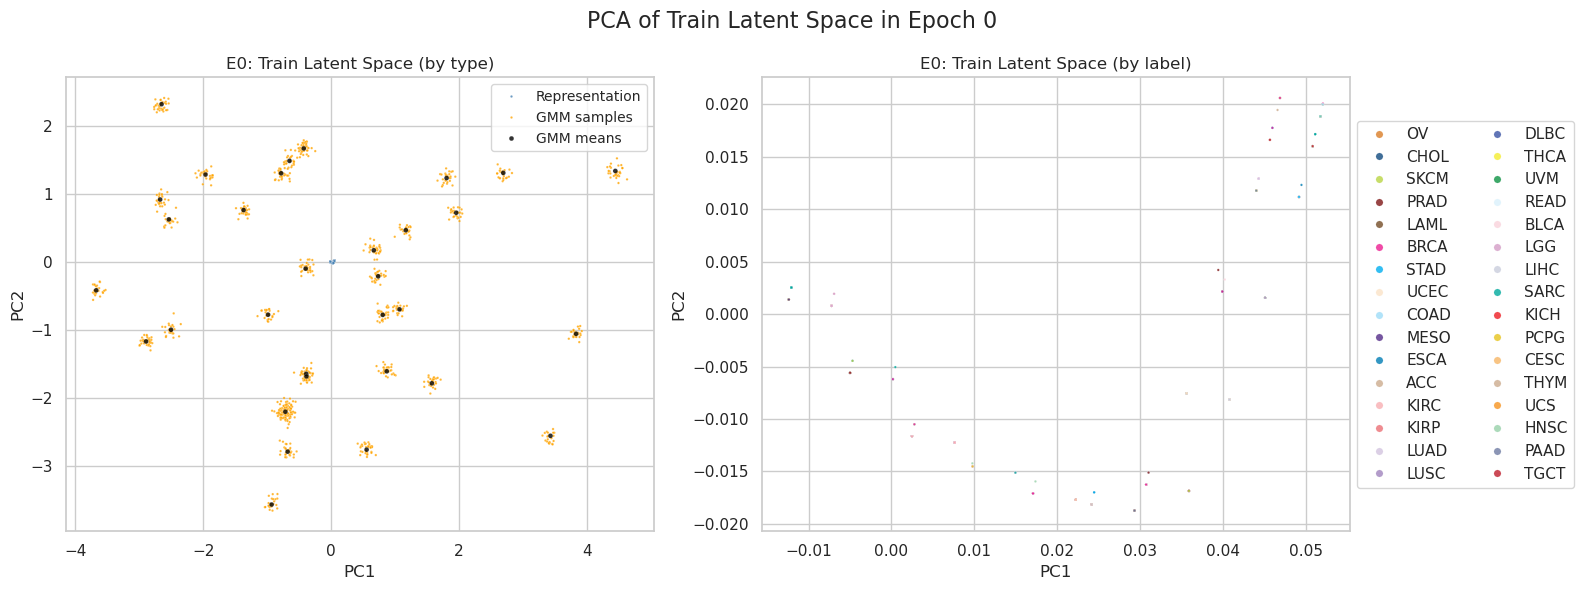

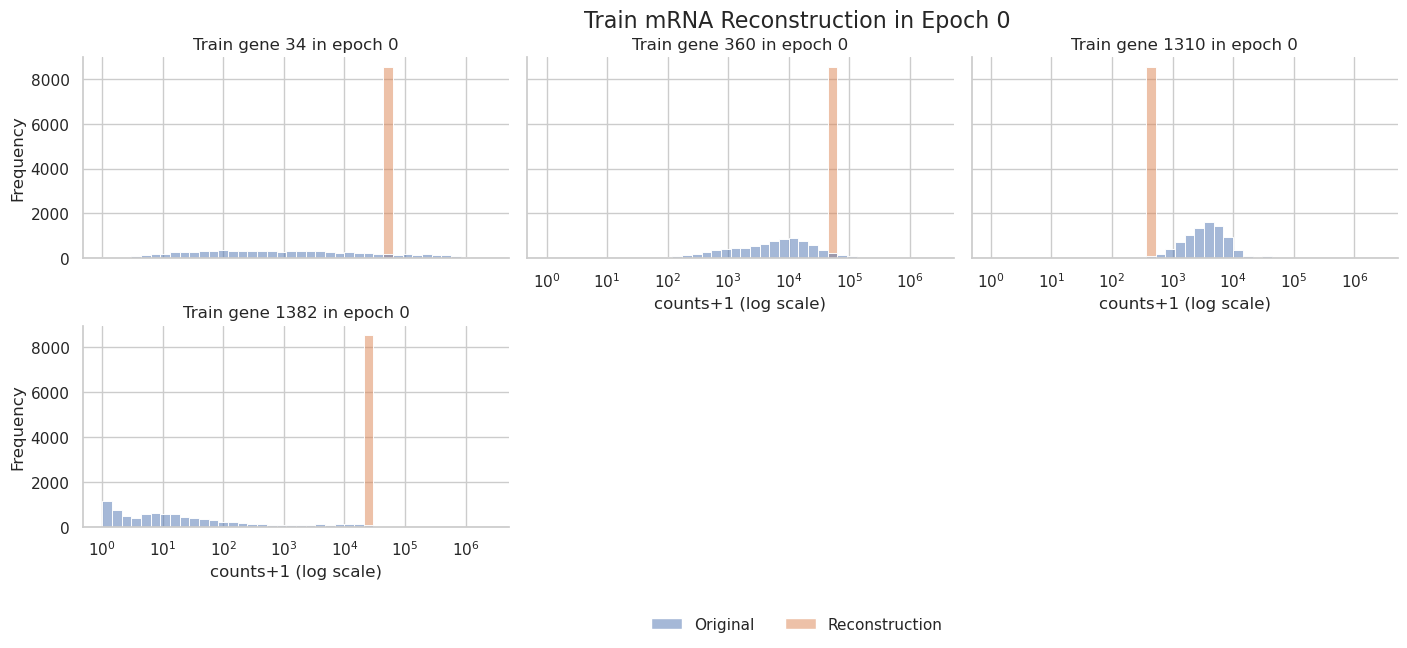

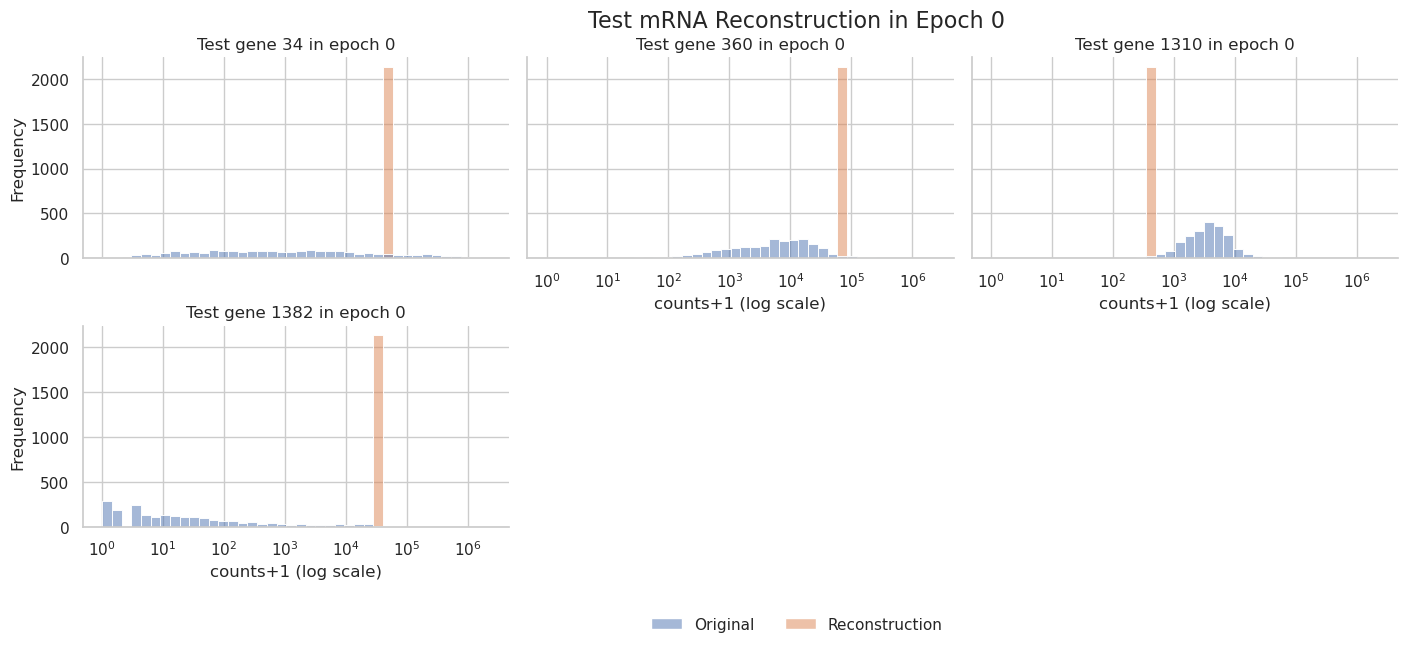

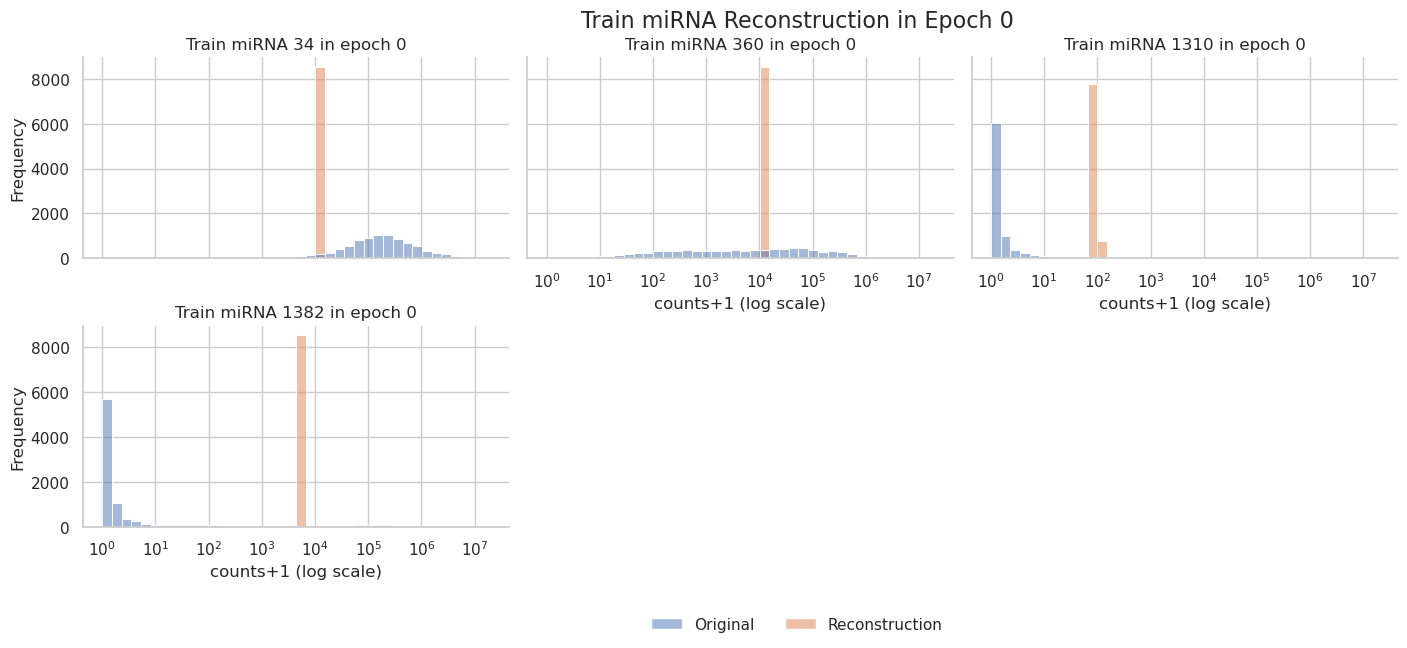

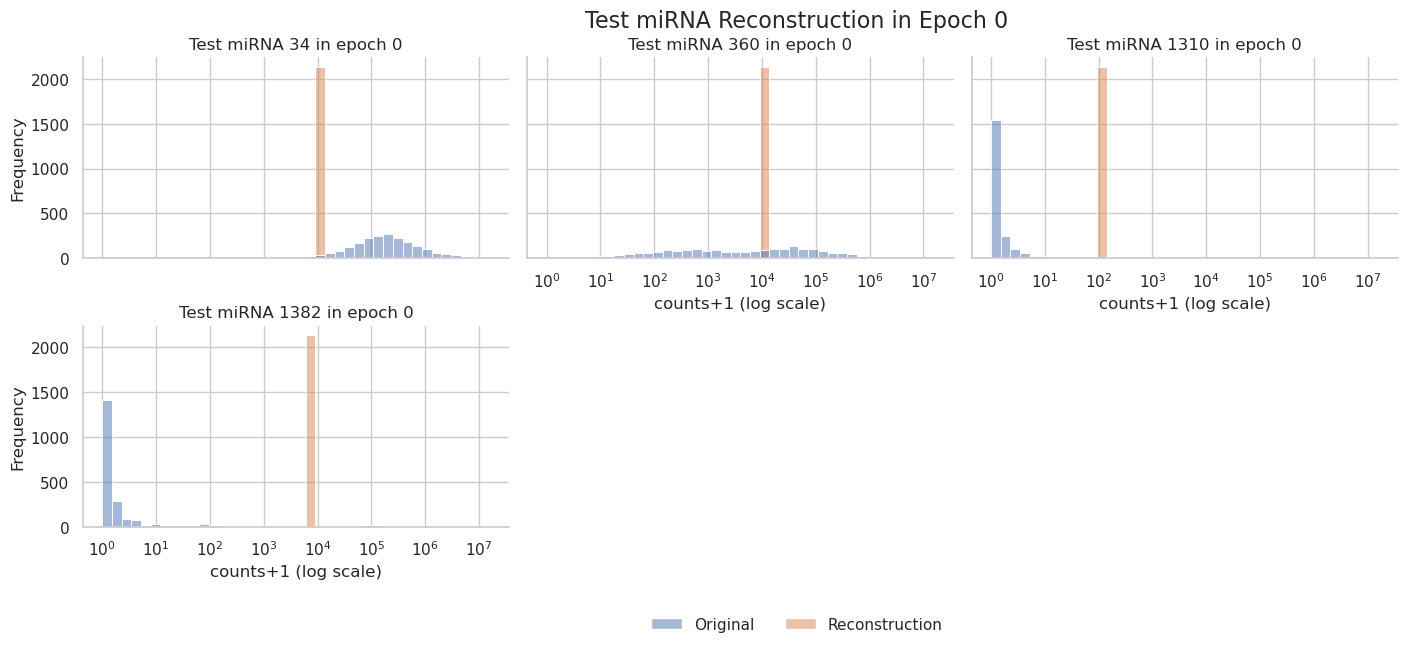

  6%|██████████▌                                                                                                                                                                      | 6/101 [01:11<16:19, 10.31s/it]

5 train_recon_mirna: 2.054131873416814 train_recon_mrna: 9.751875456674473 train_gmm: 3.2040907619931938 train_mse: 77754640.0 train_mae: 13677.817520141602 train_r2: 2.740132749080658 train_spearman: 22.591398507356644 train_pearson: 15.66465525329113 train_expl_var: 2.740133047103882 train_msle: 1042.9229640960693
5 test_recon: 19.751264522662996 test_gmm: 3.1406461908576193 test_mse: 14825430.0 test_mae: 722.9734497070312 test_r2: 0.0932013988494873 test_spearman: 0.3412400186061859 test_pearson: 0.3131704032421112 test_expl_var: 0.0932013988494873 test_msle: 18.314109802246094


 11%|███████████████████▏                                                                                                                                                            | 11/101 [01:57<13:19,  8.89s/it]

10 train_recon_mirna: 1.869028752748172 train_recon_mrna: 9.4018631264637 train_gmm: 2.933036360372146 train_mse: 74699392.5 train_mae: 11722.92465209961 train_r2: 5.265124619007111 train_spearman: 21.740192860364914 train_pearson: 18.853634476661682 train_expl_var: 5.265124440193176 train_msle: 373.73466396331787
10 test_recon: 19.159671854696935 test_gmm: 2.9265078769640978 test_mse: 14851769.0 test_mae: 712.8697509765625 test_r2: 0.09159034490585327 test_spearman: 0.3112310469150543 test_pearson: 0.3028639256954193 test_expl_var: 0.09159034490585327 test_msle: 8.852551460266113


 16%|███████████████████████████▉                                                                                                                                                    | 16/101 [02:41<12:17,  8.67s/it]

15 train_recon_mirna: 1.833540971657984 train_recon_mrna: 9.240302634660422 train_gmm: 2.874971303470799 train_mse: 74672312.625 train_mae: 11575.655731201172 train_r2: 5.287504494190216 train_spearman: 24.81449067592621 train_pearson: 18.834408909082413 train_expl_var: 5.287504434585571 train_msle: 317.51259422302246
15 test_recon: 18.860804574638845 test_gmm: 2.876353677471032 test_mse: 15810748.0 test_mae: 741.5907592773438 test_r2: 0.03293430805206299 test_spearman: 0.33504417538642883 test_pearson: 0.2086559534072876 test_expl_var: 0.03293430805206299 test_msle: 9.040465354919434


 21%|████████████████████████████████████▌                                                                                                                                           | 21/101 [03:31<12:39,  9.49s/it]

20 train_recon_mirna: 1.7643388107584954 train_recon_mrna: 9.047791867681498 train_gmm: 2.8754755053196357 train_mse: 72694698.5 train_mae: 10958.519226074219 train_r2: 6.921892166137695 train_spearman: 25.338901042938232 train_pearson: 21.722115993499756 train_expl_var: 6.921892166137695 train_msle: 298.7180609703064
20 test_recon: 18.63079067301078 test_gmm: 2.8765474698070284 test_mse: 14857385.0 test_mae: 683.4197998046875 test_r2: 0.0912468433380127 test_spearman: 0.35644957423210144 test_pearson: 0.3044627606868744 test_expl_var: 0.0912468433380127 test_msle: 8.791803359985352


 26%|█████████████████████████████████████████████▎                                                                                                                                  | 26/101 [04:20<12:18,  9.84s/it]

25 train_recon_mirna: 1.7265414376523442 train_recon_mrna: 8.91536919203747 train_gmm: 2.875236882158409 train_mse: 70313552.8125 train_mae: 10252.97200012207 train_r2: 8.88977563381195 train_spearman: 24.888035655021667 train_pearson: 24.483618438243866 train_expl_var: 8.889775812625885 train_msle: 237.66392254829407
25 test_recon: 18.859144548268745 test_gmm: 2.8763130902351066 test_mse: 14360373.0 test_mae: 649.0294189453125 test_r2: 0.12164664268493652 test_spearman: 0.35630717873573303 test_pearson: 0.35522741079330444 test_expl_var: 0.12164664268493652 test_msle: 6.561699867248535


 31%|██████████████████████████████████████████████████████                                                                                                                          | 31/101 [05:10<12:04, 10.35s/it]

30 train_recon_mirna: 1.6994875929001578 train_recon_mrna: 8.817156733021077 train_gmm: 2.8753053816140954 train_mse: 63969308.0 train_mae: 9708.485443115234 train_r2: 14.13293969631195 train_spearman: 25.603761225938797 train_pearson: 31.61804100871086 train_expl_var: 14.132939875125885 train_msle: 228.80989122390747
30 test_recon: 18.246623671940686 test_gmm: 2.876468055525076 test_mse: 13891939.0 test_mae: 637.188720703125 test_r2: 0.15029841661453247 test_spearman: 0.3471273183822632 test_pearson: 0.3909243047237396 test_expl_var: 0.15029841661453247 test_msle: 6.843752384185791


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                 | 36/101 [05:56<09:55,  9.17s/it]

35 train_recon_mirna: 1.6728534283444056 train_recon_mrna: 8.706248969555036 train_gmm: 2.8753780034442697 train_mse: 57181728.4375 train_mae: 7876.625457763672 train_r2: 19.74249505996704 train_spearman: 26.294279843568802 train_pearson: 36.512713849544525 train_expl_var: 19.742495477199554 train_msle: 166.8829665184021
35 test_recon: 17.874677539555147 test_gmm: 2.8768032116836375 test_mse: 13305425.0 test_mae: 554.633056640625 test_r2: 0.18617260456085205 test_spearman: 0.35315823554992676 test_pearson: 0.4406615197658539 test_expl_var: 0.18617260456085205 test_msle: 6.762934684753418


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 41/101 [06:53<11:07, 11.13s/it]

40 train_recon_mirna: 1.6476479457415285 train_recon_mrna: 8.61744731264637 train_gmm: 2.875206644741657 train_mse: 58979698.375 train_mae: 7895.616058349609 train_r2: 18.256573259830475 train_spearman: 27.28353390097618 train_pearson: 34.98142617940903 train_expl_var: 18.256573259830475 train_msle: 104.07079148292542
40 test_recon: 17.67537634716808 test_gmm: 2.876728735077247 test_mse: 12878340.0 test_mae: 539.9454345703125 test_r2: 0.2122952938079834 test_spearman: 0.3643829822540283 test_pearson: 0.46966516971588135 test_expl_var: 0.2122952938079834 test_msle: 5.036439895629883


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 46/101 [07:47<10:03, 10.98s/it]

45 train_recon_mirna: 1.629944221072504 train_recon_mrna: 8.553765040983606 train_gmm: 2.8749375783308326 train_mse: 53902298.375 train_mae: 7405.247673034668 train_r2: 22.452760934829712 train_spearman: 27.70154994726181 train_pearson: 38.990755558013916 train_expl_var: 22.452760934829712 train_msle: 100.52323472499847
45 test_recon: 17.559365350072614 test_gmm: 2.8768058291088776 test_mse: 12443988.0 test_mae: 538.8629760742188 test_r2: 0.23886245489120483 test_spearman: 0.36649274826049805 test_pearson: 0.49192240834236145 test_expl_var: 0.23886245489120483 test_msle: 5.229189395904541


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 50/101 [08:35<10:14, 12.05s/it]

50 train_recon_mirna: 1.6132458837164843 train_recon_mrna: 8.492979326697892 train_gmm: 2.8746926601150835 train_mse: 51156136.875 train_mae: 7142.072929382324 train_r2: 24.722310543060303 train_spearman: 28.29599839448929 train_pearson: 41.094710409641266 train_expl_var: 24.722310066223145 train_msle: 91.4004499912262
50 test_recon: 17.520554393105556 test_gmm: 2.8766848103383955 test_mse: 12288132.0 test_mae: 531.7461547851562 test_r2: 0.2483953833580017 test_spearman: 0.3826020658016205 test_pearson: 0.5025036931037903 test_expl_var: 0.24839544296264648 test_msle: 4.264547348022461


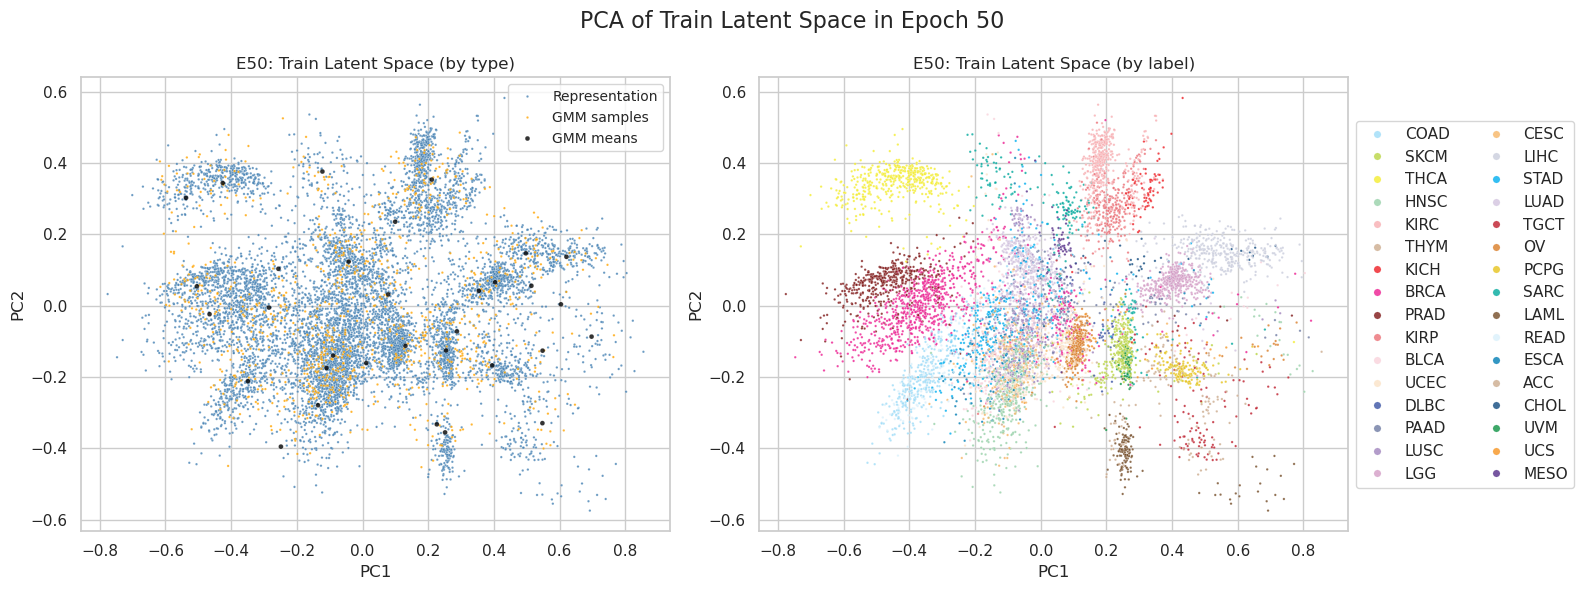

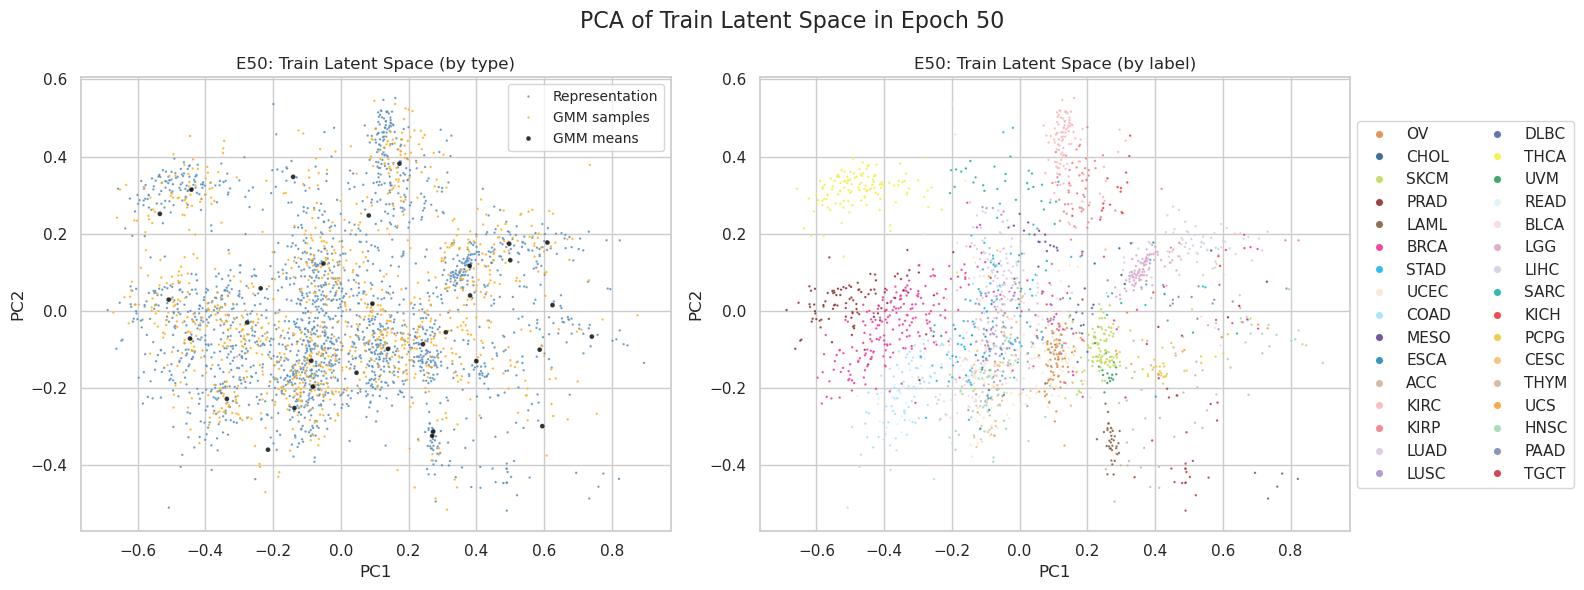

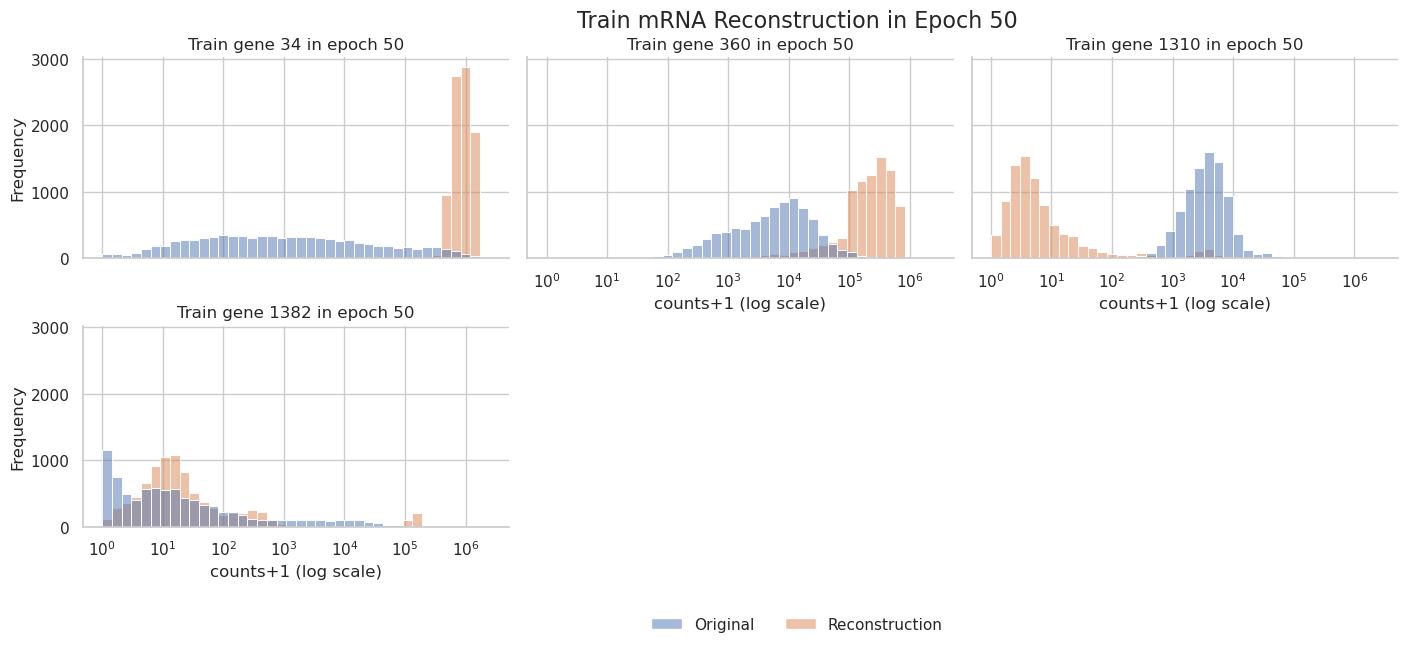

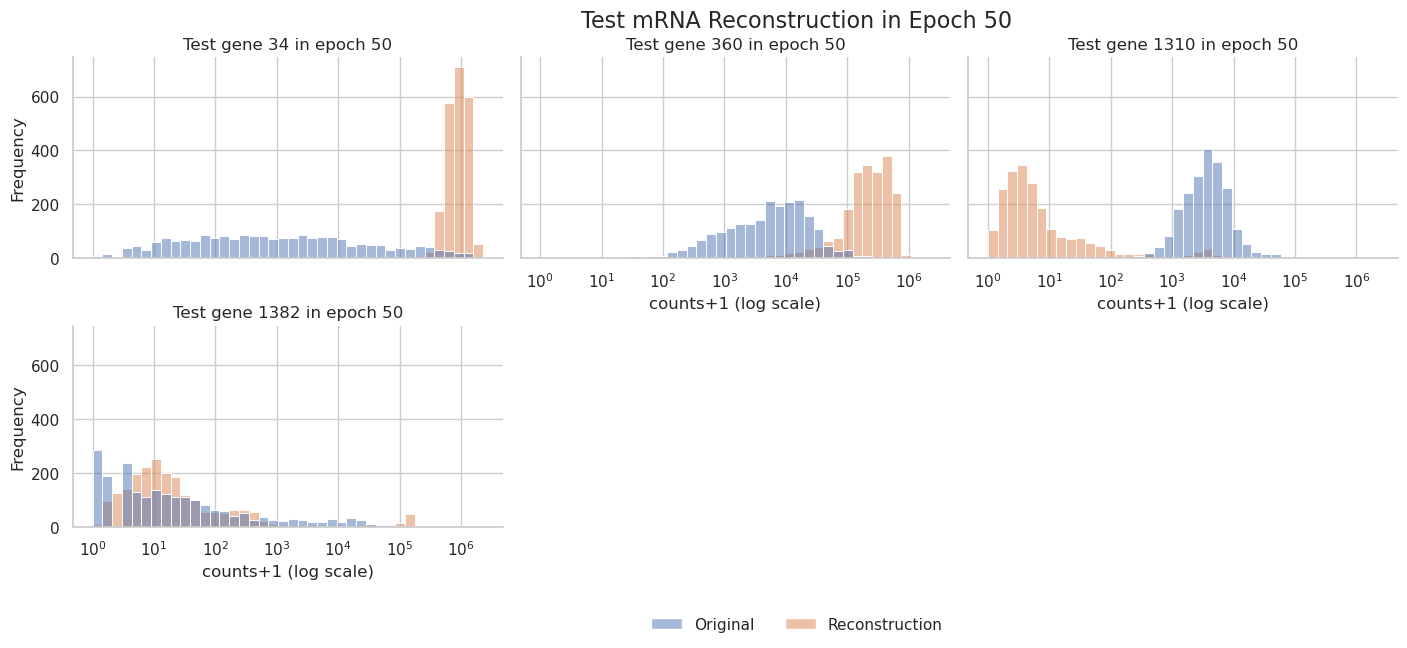

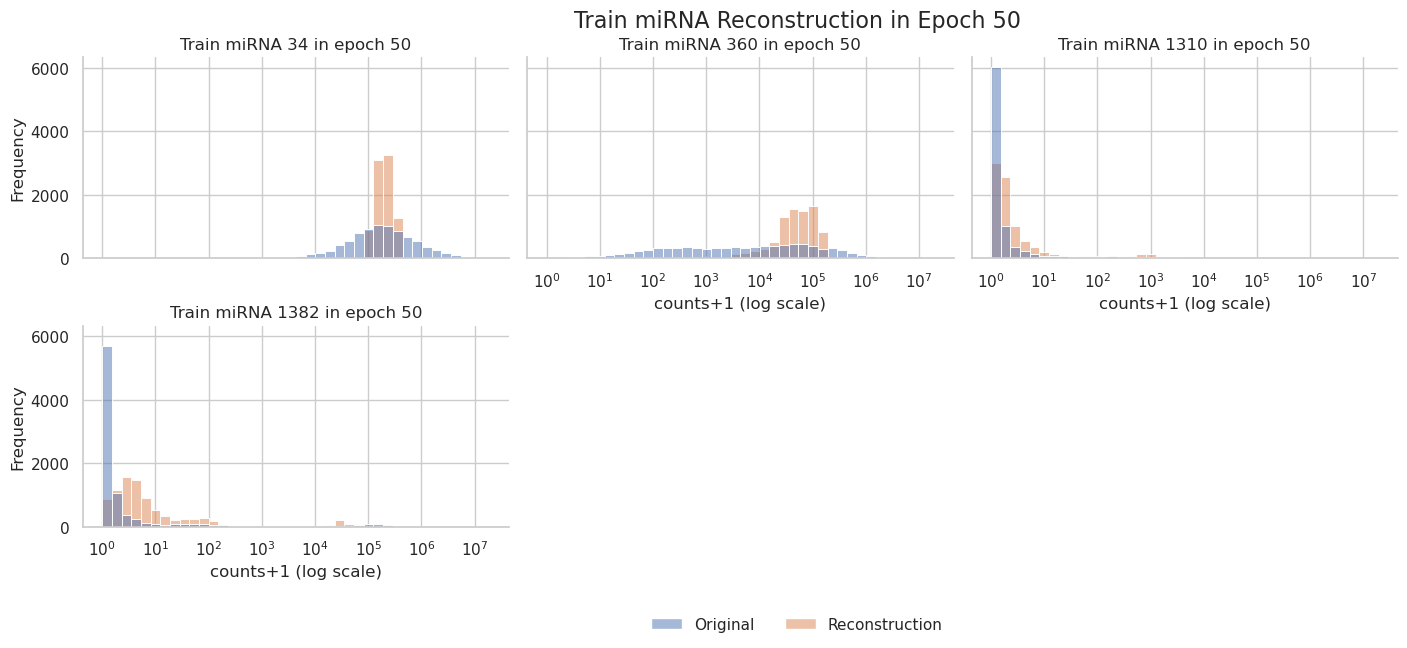

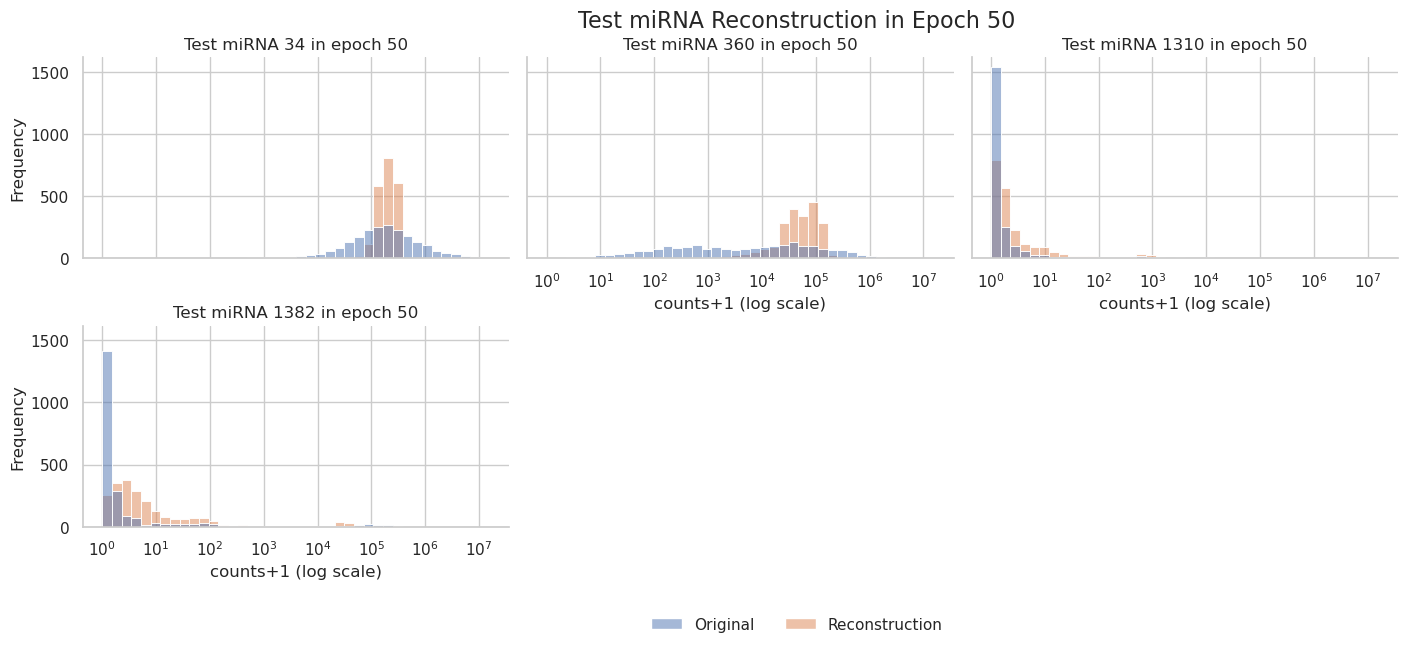

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 56/101 [10:06<10:11, 13.58s/it]

55 train_recon_mirna: 1.6011599779548822 train_recon_mrna: 8.44144919203747 train_gmm: 2.8747142925753804 train_mse: 52065833.0625 train_mae: 7198.522888183594 train_r2: 23.970496833324432 train_spearman: 28.591670095920563 train_pearson: 40.30874675512314 train_expl_var: 23.970496892929077 train_msle: 86.96054756641388
55 test_recon: 17.412893975005733 test_gmm: 2.8768967303443937 test_mse: 12677111.0 test_mae: 527.059326171875 test_r2: 0.22460341453552246 test_spearman: 0.38904210925102234 test_pearson: 0.48745590448379517 test_expl_var: 0.22460347414016724 test_msle: 4.003695487976074


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 61/101 [10:55<06:59, 10.49s/it]

60 train_recon_mirna: 1.5911616059479998 train_recon_mrna: 8.395473782201405 train_gmm: 2.8751151892061255 train_mse: 54174433.5625 train_mae: 7320.599456787109 train_r2: 22.227856397628784 train_spearman: 28.83734107017517 train_pearson: 38.618693709373474 train_expl_var: 22.227856516838074 train_msle: 79.085196018219
60 test_recon: 17.232211075441413 test_gmm: 2.877193299482824 test_mse: 12671762.0 test_mae: 513.97900390625 test_r2: 0.22493064403533936 test_spearman: 0.3923909068107605 test_pearson: 0.4903929829597473 test_expl_var: 0.22493064403533936 test_msle: 3.343188524246216


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 66/101 [11:51<06:08, 10.54s/it]

65 train_recon_mirna: 1.5824003145461931 train_recon_mrna: 8.356750614754098 train_gmm: 2.8757841631065206 train_mse: 56484046.8125 train_mae: 7447.790939331055 train_r2: 20.319090127944946 train_spearman: 29.374653786420822 train_pearson: 36.91602444648743 train_expl_var: 20.31909018754959 train_msle: 70.76662814617157
65 test_recon: 17.131572173813346 test_gmm: 2.877971463435598 test_mse: 13141516.0 test_mae: 517.4623413085938 test_r2: 0.19619810581207275 test_spearman: 0.38962703943252563 test_pearson: 0.47052836418151855 test_expl_var: 0.19619810581207275 test_msle: 3.3748605251312256


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 71/101 [12:39<04:56,  9.90s/it]

70 train_recon_mirna: 1.5735169400898532 train_recon_mrna: 8.32519299765808 train_gmm: 2.8765332002662105 train_mse: 57135835.375 train_mae: 7455.109184265137 train_r2: 19.780423402786255 train_spearman: 29.304934114217758 train_pearson: 36.456400990486145 train_expl_var: 19.780423521995544 train_msle: 68.06134939193726
70 test_recon: 17.066237627073303 test_gmm: 2.878916331087605 test_mse: 13427751.0 test_mae: 518.4471435546875 test_r2: 0.17869049310684204 test_spearman: 0.38712725043296814 test_pearson: 0.4606398046016693 test_expl_var: 0.17869055271148682 test_msle: 2.9795610904693604


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 76/101 [13:36<04:31, 10.85s/it]

75 train_recon_mirna: 1.5655627972207617 train_recon_mrna: 8.298497476580796 train_gmm: 2.8772732751207553 train_mse: 57115380.375 train_mae: 7441.924530029297 train_r2: 19.797328054904938 train_spearman: 29.142254948616028 train_pearson: 36.49721670150757 train_expl_var: 19.797327935695648 train_msle: 66.63171887397766
75 test_recon: 17.013858872200565 test_gmm: 2.8797226466489643 test_mse: 12819450.0 test_mae: 508.77532958984375 test_r2: 0.21589726209640503 test_spearman: 0.3973841369152069 test_pearson: 0.4861891269683838 test_expl_var: 0.2158973217010498 test_msle: 2.5908799171447754


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 81/101 [14:21<03:08,  9.42s/it]

80 train_recon_mirna: 1.5587130072169384 train_recon_mrna: 8.274328922716627 train_gmm: 2.878149848598507 train_mse: 54243746.1875 train_mae: 7190.558532714844 train_r2: 22.170573353767395 train_spearman: 29.417699575424194 train_pearson: 38.53908920288086 train_expl_var: 22.17057341337204 train_msle: 65.82713717222214
80 test_recon: 16.963335244210043 test_gmm: 2.880554142069727 test_mse: 12401718.0 test_mae: 503.60333251953125 test_r2: 0.24144792556762695 test_spearman: 0.40159696340560913 test_pearson: 0.5059121251106262 test_expl_var: 0.24144792556762695 test_msle: 2.9863688945770264


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 86/101 [15:11<02:31, 10.11s/it]

85 train_recon_mirna: 1.552937850989342 train_recon_mrna: 8.252759748243559 train_gmm: 2.879158946982033 train_mse: 51729305.0625 train_mae: 6956.9572677612305 train_r2: 24.248618960380554 train_spearman: 29.62900158762932 train_pearson: 40.33477175235748 train_expl_var: 24.24861866235733 train_msle: 67.31912076473236
85 test_recon: 16.912061119391577 test_gmm: 2.881632052646594 test_mse: 11664716.0 test_mae: 488.53851318359375 test_r2: 0.2865266799926758 test_spearman: 0.3994698226451874 test_pearson: 0.542313277721405 test_expl_var: 0.28652673959732056 test_msle: 2.979459285736084


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 91/101 [15:55<01:33,  9.37s/it]

90 train_recon_mirna: 1.5479821129857094 train_recon_mrna: 8.23259768735363 train_gmm: 2.8801323190729287 train_mse: 48721599.0 train_mae: 6694.999359130859 train_r2: 26.734319806098938 train_spearman: 29.792265594005585 train_pearson: 42.46497964859009 train_expl_var: 26.73431968688965 train_msle: 69.28517842292786
90 test_recon: 16.87040878430024 test_gmm: 2.8825936421026452 test_mse: 10908627.0 test_mae: 469.90545654296875 test_r2: 0.3327729105949402 test_spearman: 0.3955967128276825 test_pearson: 0.5793644785881042 test_expl_var: 0.33277297019958496 test_msle: 3.033421277999878


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 96/101 [16:35<00:42,  8.45s/it]

95 train_recon_mirna: 1.5433034907757013 train_recon_mrna: 8.214319045667448 train_gmm: 2.8811916235180037 train_mse: 47016406.9375 train_mae: 6522.284996032715 train_r2: 28.143566071987152 train_spearman: 29.625924110412598 train_pearson: 43.63076597452164 train_expl_var: 28.14356553554535 train_msle: 70.60042142868042
95 test_recon: 16.830902889245586 test_gmm: 2.8837572647837666 test_mse: 10437859.0 test_mae: 455.5887756347656 test_r2: 0.36156749725341797 test_spearman: 0.40504956245422363 test_pearson: 0.6020596027374268 test_expl_var: 0.36156749725341797 test_msle: 2.894083261489868


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [17:10<00:08,  8.42s/it]

100 train_recon_mirna: 1.538838210342685 train_recon_mrna: 8.197325421545667 train_gmm: 2.882074206171326 train_mse: 46471902.3125 train_mae: 6412.075637817383 train_r2: 28.59356838464737 train_spearman: 29.77834415435791 train_pearson: 43.951509952545166 train_expl_var: 28.59356850385666 train_msle: 66.25771999359131
100 test_recon: 16.795172791026523 test_gmm: 2.884559728500995 test_mse: 10493243.0 test_mae: 455.1962585449219 test_r2: 0.3581799268722534 test_spearman: 0.4042142629623413 test_pearson: 0.5993127226829529 test_expl_var: 0.3581799268722534 test_msle: 2.9080824851989746


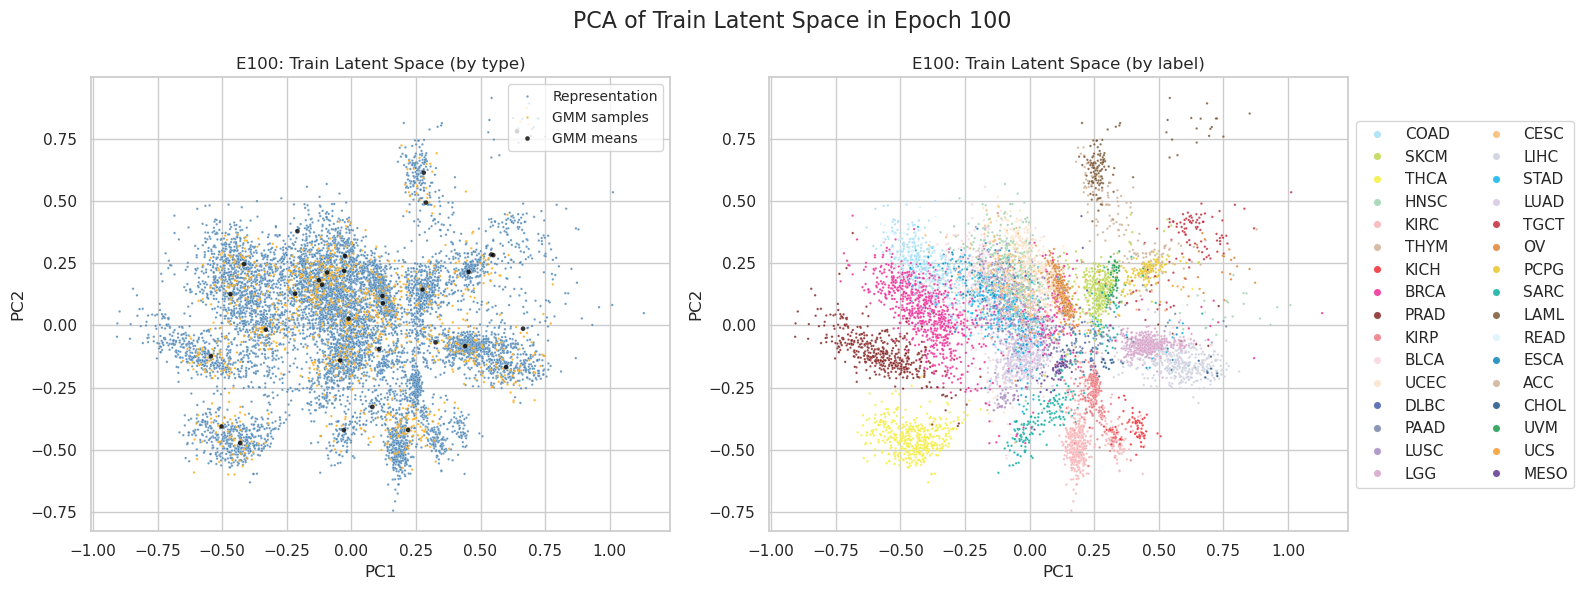

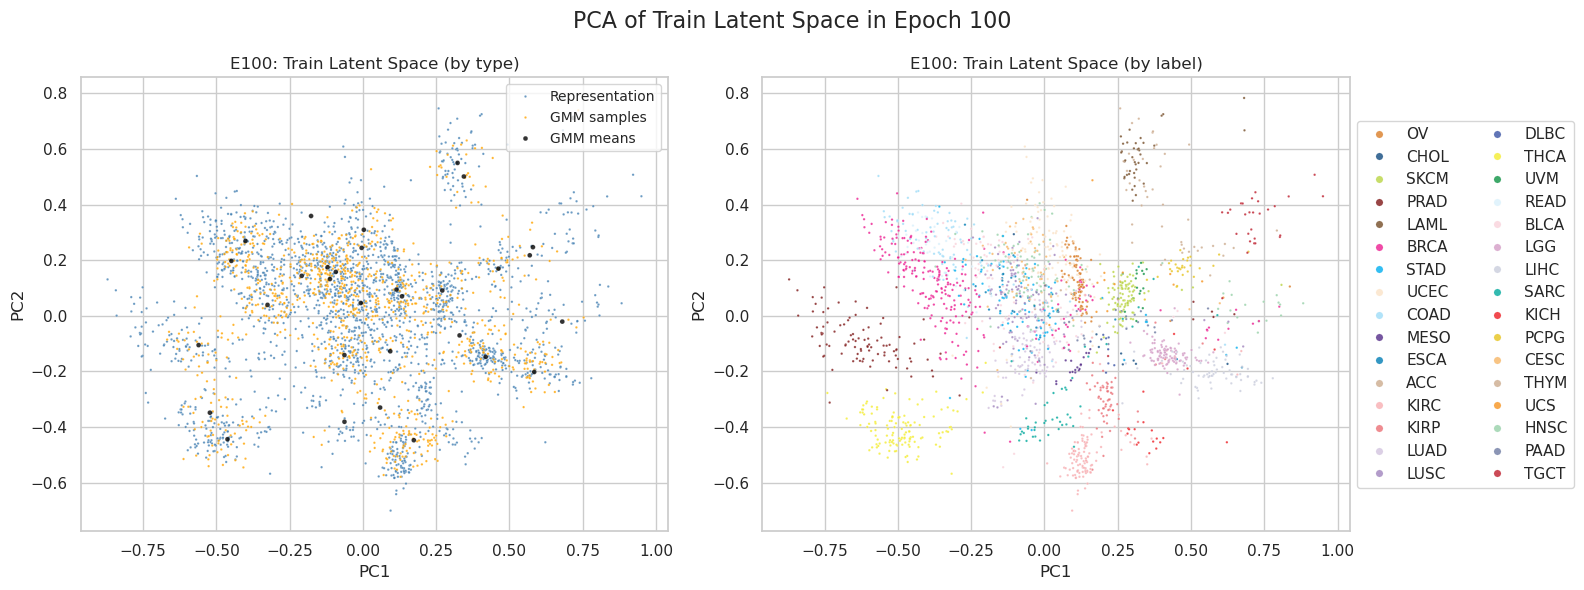

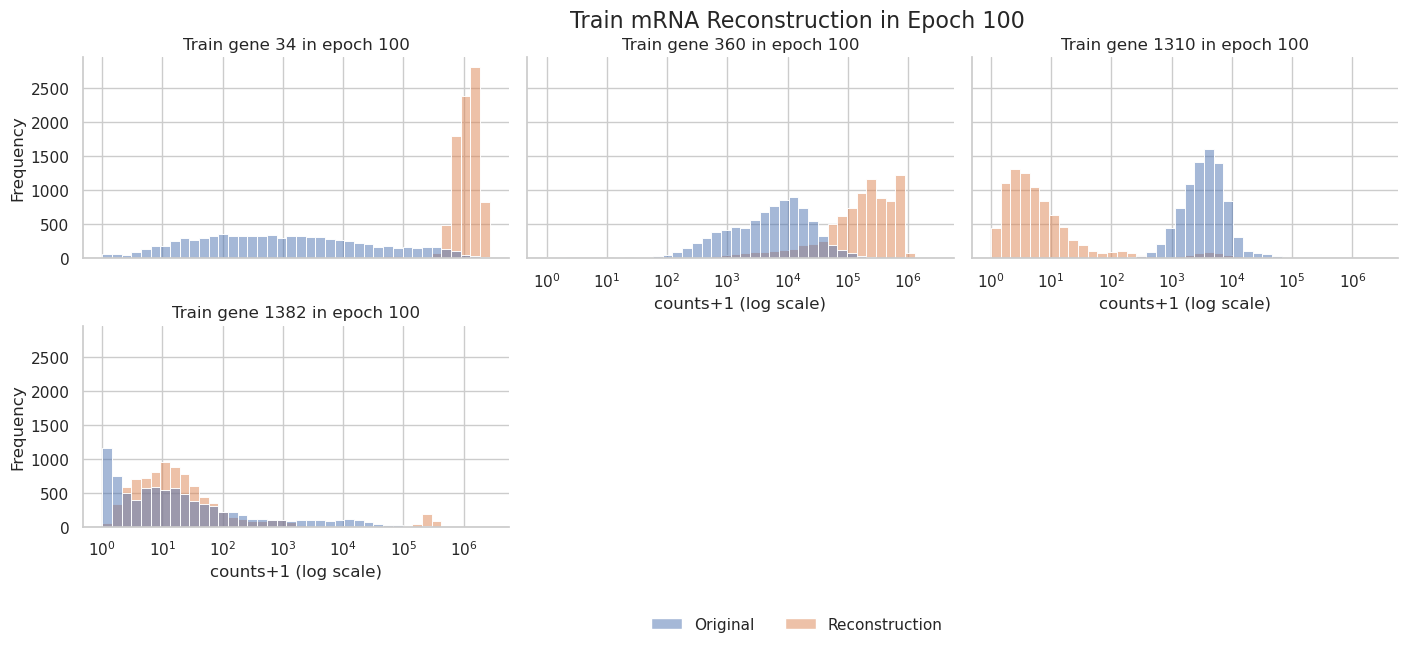

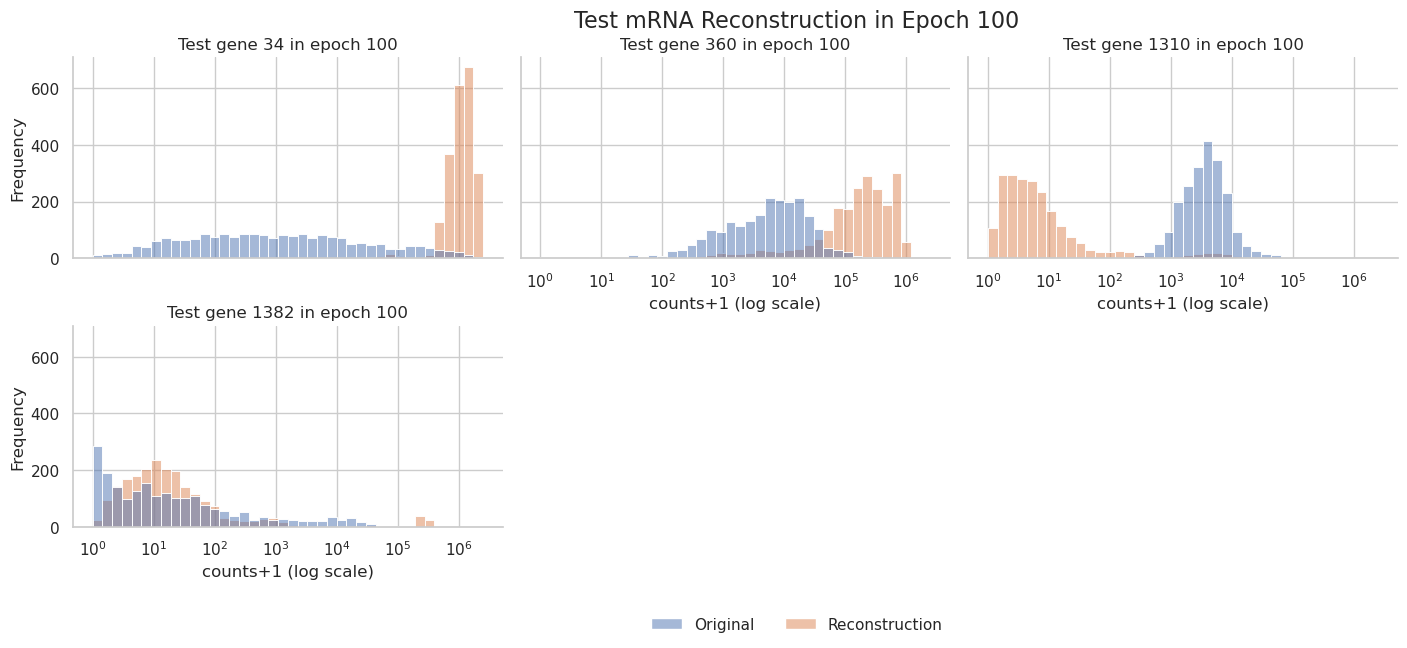

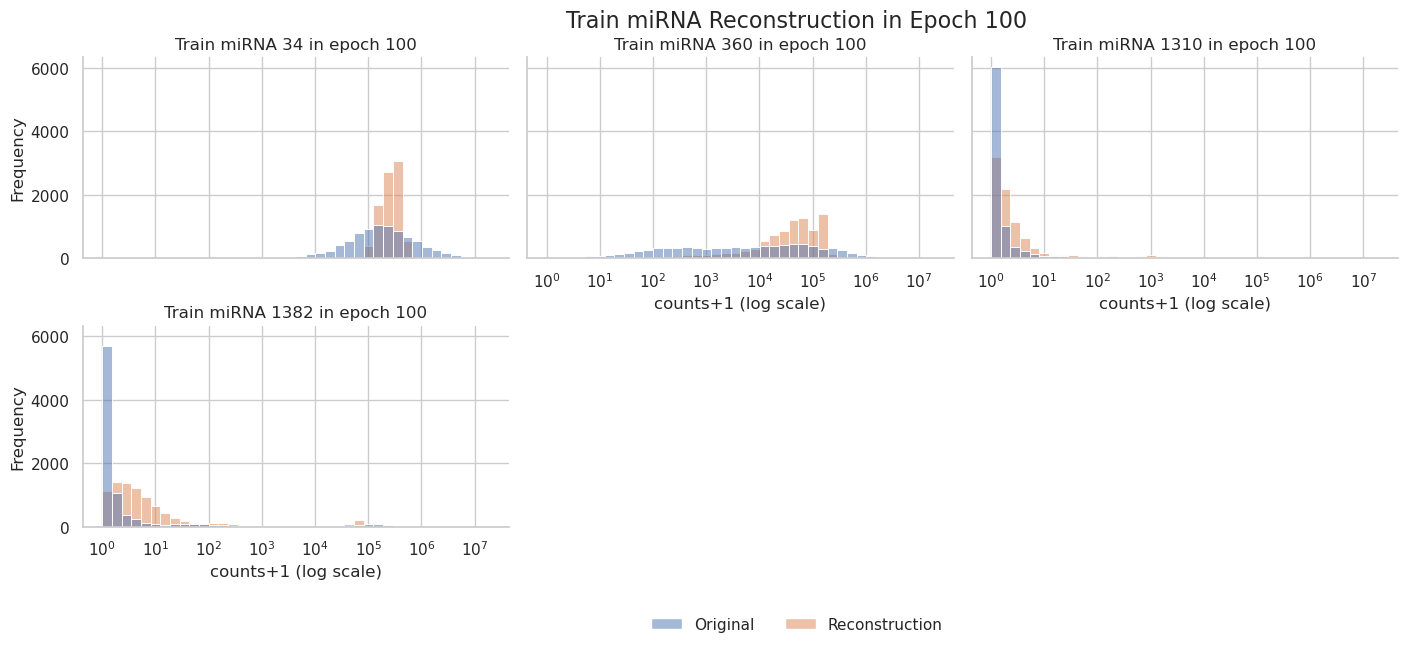

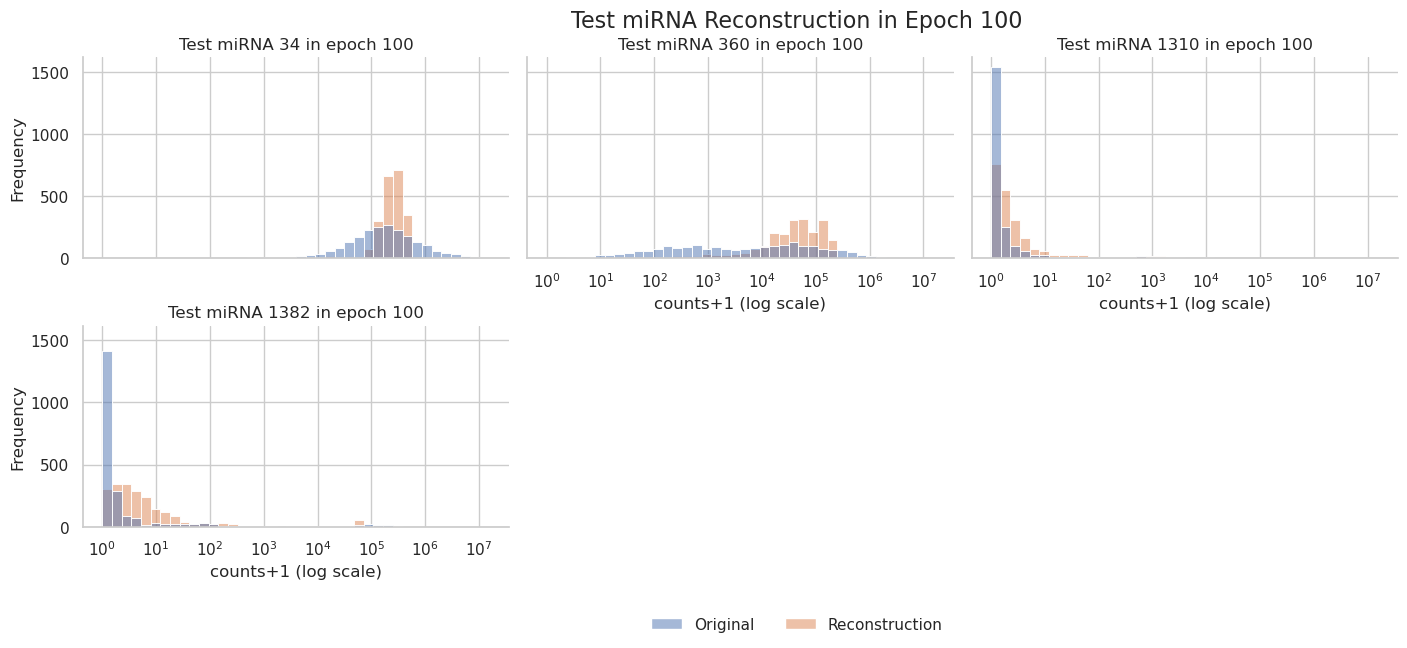

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [17:35<00:00, 10.45s/it]


In [19]:
loss_tab = train_midgd(
        dgd, train_loader, validation_loader, device, train_dataset, validation_dataset,
        learning_rates=learning_rates,
        weight_decay=weight_decay, betas=betas, nepochs=nepochs,
        pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, wandb_log=False
    )

# Plotting Loss

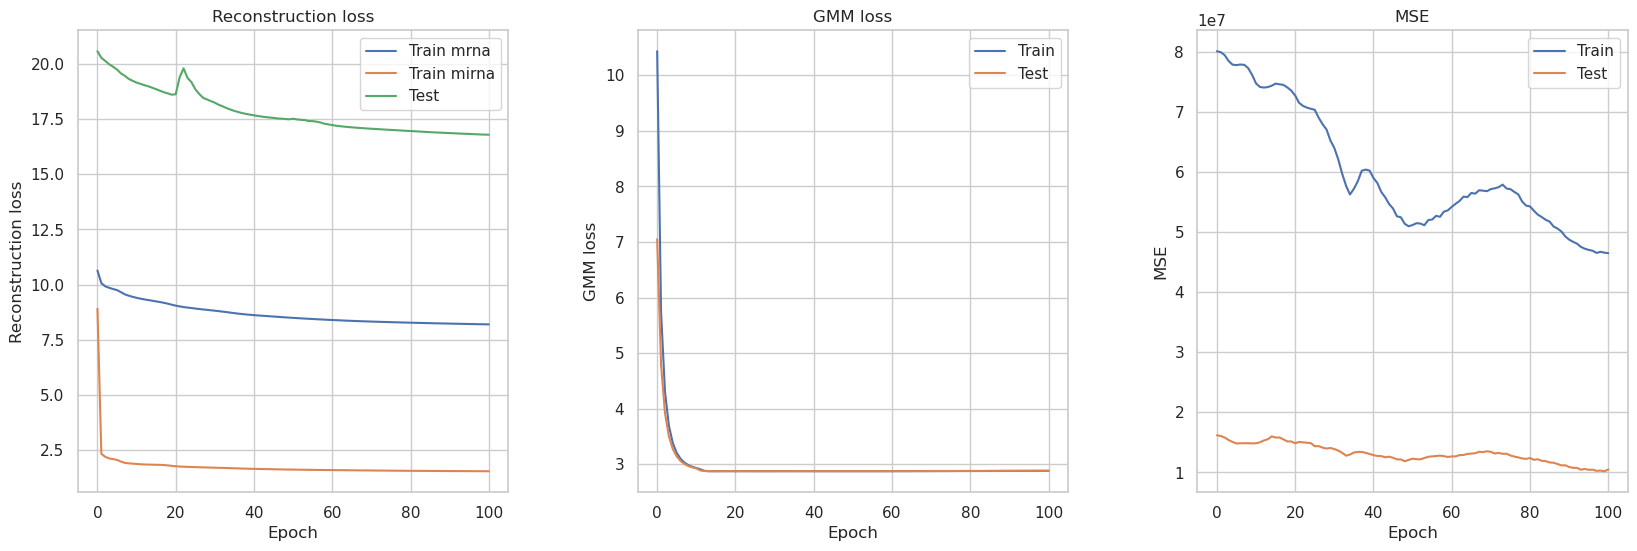

In [55]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon_mrna", data=loss_tab, label="Train mrna")
sns.lineplot(x="epoch", y="train_recon_mirna", data=loss_tab, label="Train mirna")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Display the plots
plt.show()

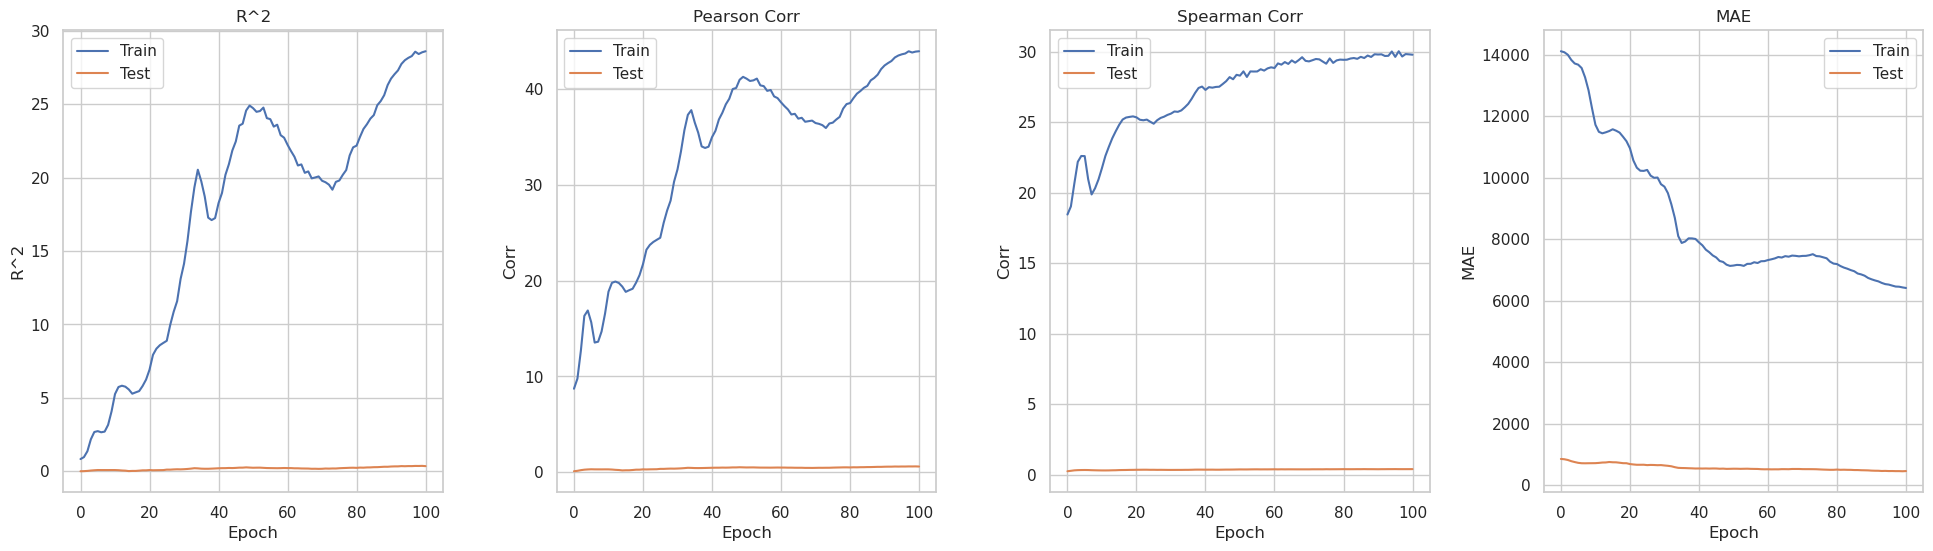

In [28]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Third subplot for MSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Fourth subplot for MAE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()

In [54]:
dgd.decoder

Decoder(
  (main): ModuleList(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (out_modules): ModuleList(
    (0): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=2450, bias=True)
      )
    )
    (1): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=5000, bias=True)
      )
    )
  )
)

# Plotting

In [ ]:
from base.data.dataset import GeneExpressionDataset

def plot_mirna_recons(dgd, train_loader, sample_index, epoch):
    x_mirna_n = [None] * len(sample_index)
    lib_mirna_n = [None] * len(sample_index)
    res_mirna_n = [None] * len(sample_index)

    # Get mRNA data
    for i, j in enumerate(sample_index):
        # Get training data
        x_mirna_n[i] = train_loader.dataset.data[:,j] + 1
        ## miRNA
        x_mirna_n[i] = x_mirna_n[i].cpu().detach().numpy()
        lib_mirna_n[i] = torch.mean(train_loader.dataset.data).cpu().detach().numpy()
        
        # Get gene reconstructions via forward method
        res_mirna_n[i] = dgd.forward(dgd.train_rep.z)
        ## miRNA
        res_mirna_n[i] = res_mirna_n[i][0].cpu().detach().numpy()
        res_mirna_n[i] = res_mirna_n[i][:,j] 
        res_mirna_n[i] = (res_mirna_n[i] * lib_mirna_n[i]) + 1
        
    # Plot initialization and cosmetics
    fig, ax = plt.subplots(nrows=1, ncols=len(sample_index), figsize=(20,4))
    fig.subplots_adjust(hspace=0.5)
    sns.set_theme(style="whitegrid")

    # Plot row 1 for miRNA
    for i, j in enumerate(sample_index):
        data = {
            'value': np.concatenate((x_mirna_n[i], res_mirna_n[i])),
            'type': ['Original'] * len(x_mirna_n[i]) + ['Reconstruction'] * len(res_mirna_n[i])
        }
        plotdata = pd.DataFrame(data)
        
        sns.histplot(data=plotdata, x='value', hue='type', ax=ax[i], log_scale=True, bins=40)
        ax[i].set_title(f'miRNA {j} in epoch {epoch}')
        ax[i].set_xlabel('counts+1 (log scale)')
        ax[i].set_ylabel(None)

    ax[0].set_ylabel('Frequency')
    
    plt.show()

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
epoch = 11
mirna_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_mirna), 
                                           batch_size=256, 
                                           shuffle=True,
                                           num_workers=num_workers,
                                           pin_memory=True)

plot_mirna_recons(dgd, mirna_loader, sample_index, epoch)